In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import numpy as np
import gymnasium as gym
from gymnasium import spaces

def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / (np.sum(e_x, axis=1, keepdims=True) + 1e-16)

class MAMGEnv(gym.Env):
    def __init__(self):
        super(MAMGEnv, self).__init__()
        self.num_agents = 2
        self.env_size = 3
        self.num_goals = 2
        self.goals = np.array([[1,1.1], [0,1]]) * self.env_size #np.random.rand(self.num_goals, 2) * self.env_size
        self.state_size = self.num_agents * 2
        self.action_size = 2
        self.lambda_reg = 0.001
        self.alpha_reg = 0.001
        self.prior = np.zeros(self.num_goals) + 1.0 / self.num_goals
        self.convergence_reward = 100
        self.reward_configs = [tuple(np.repeat(i, self.num_agents)) for i in range(self.num_goals)]
        self.total_cost = 0

        self.observation_space = spaces.Box(low=0, high=self.env_size, shape=(self.state_size,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.num_agents, self.action_size), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.positions = np.array([[0,0],[1,0]])*self.env_size#np.random.rand(self.num_agents, 2) * self.env_size
        self.timesteps = 0
        self.total_cost = 0
        self.prior = np.zeros(self.num_goals) + 1.0 / self.num_goals
        return (self.positions.flatten().astype(np.float32), {})

    def step(self, action):
        actions = action.reshape((self.num_agents, 2))
        self.positions = np.clip(self.positions + actions, 0, self.env_size)
        self.timesteps += 1

        free_energy_cost, distances = self._compute_cost(self.positions, self.goals)
        movement_cost = self.lambda_reg * np.sum(actions**2)
        min_goal = np.argmin(self.prior)
        belief_goal_dist_cost = self.alpha_reg * np.sum([distances[i,min_goal] for i in range(self.num_agents)])
        total_cost = free_energy_cost + movement_cost + belief_goal_dist_cost

        self.total_cost += total_cost[0]

        terminated = bool(self.timesteps >= 10)
        truncated = False
        obs = self.positions.flatten().astype(np.float32)
        
        reward = -self.total_cost
        return obs, reward, terminated, truncated, {}
    
    def custom_cdist(self, x, goals, types = None):
        """
        Compute the pairwise distance between rows of x1 and rows of x2 based on measurement types.

        Args:
            x (np.ndarray): An array of shape (m, d)
            goals (np.ndarray): An array of shape (n, d)
            types (list): A list of measurement types for each pair of rows.
        Returns:
            np.ndarray: An array of shape (m, n) with the pairwise evidences.
        """
        # assert len(types) == x.shape[0], "Length of types must match number of rows in x"

        # Compute the pairwise differences to goals
        diff_to_goals = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
        
        # Compute the pairwise distances to goals
        distances_to_goals = np.linalg.norm(diff_to_goals, axis=2)
        
        # Compute the pairwise angles to goals
        angles_to_goal = np.arctan2(diff_to_goals[:, :, 1], diff_to_goals[:, :, 0])
        
        # Compute the pairwise differences between robots
        diff_to_robot = x[:, np.newaxis, :] - x[np.newaxis, :, :]
        
        # Compute the pairwise angles between robots
        angles_to_robot = np.arctan2(diff_to_robot[:, :, 1], diff_to_robot[:, :, 0])
        
        # Compute the relative angles
        relative_angles = np.abs((angles_to_goal[np.newaxis, :, :] - angles_to_robot[:, :, np.newaxis] + np.pi) % (2 * np.pi) - np.pi)
        
        # Using cosine to value alignment, where 1 means perfectly aligned and -1 means opposite
        alignment = 1 - np.cos(relative_angles)
        # TODO: Utilize alignment for different type of bot

        return distances_to_goals

    def calculate_joint_goal_probs(self,agent_poses, goals, predict_types = None, reward_configs = None, eta = 10):
        """
        Calculate the joint goal probabilities for any number of agents and goals,
        applying a reward to specified configurations.

        Parameters:
        - agent_poses (np.ndarray): Array of shape [num_agents, 2] representing the positions of agents.
        - goals (np.ndarray): Array of shape [num_goals, 2] representing the positions of goals.
        - predict_types (list): List of types for prediction
        - reward_configs (list of tuples): List of configurations to reward. Each configuration is a tuple of goal indices.
        
        Returns:
        - joint_probabilities (np.ndarray): Array representing the joint probabilities.
        """
        num_agents = agent_poses.shape[0]
        num_goals = goals.shape[0]

        # Calculate distances between agents and goals
        distances = self.custom_cdist(agent_poses, goals)
        evidence = eta * np.exp(-1.0 / eta * distances)

        # Convert distances to probabilities using softmax
        probabilities = softmax(evidence) # Apply softmax along the goal dimension

        # Initialize joint probabilities as an array of ones with the appropriate shape
        joint_probabilities = np.ones([num_goals] * num_agents, dtype=float)

        # Calculate joint probabilities
        for i in range(num_agents):
            joint_probabilities *= probabilities[i].reshape([num_goals if j == i else 1 for j in range(num_agents)]) 

        # Only return the specified configurations
        likelihood = np.array([joint_probabilities[tuple(config)] for config in self.reward_configs], dtype=np.float64)

        # Normalize the joint probabilities
        likelihood = softmax(likelihood)

        return likelihood

    def _compute_distance(self, x, goals):
        diff = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        return distances

    def _compute_evidence(self, x, goals, eta=10):
        distances = self._compute_distance(x, goals)
        return eta * np.exp(-1.0 / eta * distances), distances

    def _compute_entropy(self, evidence):
        sum_evidence = np.sum(evidence, axis=0)
        max_sum_evidence = np.max(sum_evidence)
        likelihood = np.exp(-(sum_evidence - max_sum_evidence)) / (np.sum(np.exp(-(sum_evidence - max_sum_evidence)) + 1e-16))
        # likelihood = np.exp(-sum_evidence) / np.sum(np.exp(-sum_evidence))
        self.posterior = softmax(likelihood * self.prior)
        total_cost = -np.dot(self.posterior, np.log(self.posterior.T)).reshape(-1).astype(np.float64)
        return total_cost

    def _compute_cost(self, x, goals):
        # evidence = self.calculate_joint_goal_probs(x, goals)
        evidence, distances = self._compute_evidence(x, goals)
        return self._compute_entropy(evidence) * 1e1, distances

    def _check_convergence(self, threshold=0.1):
        distances_to_goals = self._compute_distance(self.positions, self.goals)
        distances_to_selected_goal = [np.min(distances) for distances in distances_to_goals]
        selected_goals = [np.argmin(distances) for distances in distances_to_goals]
        all_same_goal = [selected_goals[0] == which_goal for which_goal in selected_goals]
        check = (np.array(distances_to_selected_goal) < threshold).all() and all(all_same_goal)
        return check


# Register the custom environment
register(
    id='MAMGEnv-v0',
    entry_point='__main__:MAMGEnv',
)


c:\Users\qbr5kx\Anaconda3\lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment MyMultiAgentEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [10]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

def optimize_ppo(trial):
    """ Optimization function for PPO """
    
    # Hyperparameters to tune
    n_steps = trial.suggest_categorical('n_steps', [1024, 2048])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.9, 0.9999, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Reduced upper bound for stability
    ent_coef = trial.suggest_float('ent_coef', 1e-8, 0.1, log=True)  # Ensuring a very small lower bound
    
    env = make_vec_env('MyMultiAgentEnv-v0', n_envs=1)
    
    model = PPO(
        'MlpPolicy',
        env,
        n_steps=n_steps,
        batch_size=batch_size,
        gamma=gamma,
        learning_rate=learning_rate,
        ent_coef=ent_coef,
        verbose=0
    )
    
    try:
        model.learn(total_timesteps=10000)
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    except Exception as e:
        print(f"An error occurred during training: {e}")
        return -np.inf  # Return a very low reward in case of error to discard this trial
    
    return mean_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_ppo, n_trials=50)

print('Best hyperparameters: ', study.best_params)
best_params = study.best_params


[I 2024-06-16 17:21:25,677] A new study created in memory with name: no-name-8bb9ce42-1693-404a-8de1-33a0ba9bda2b
c:\Users\qbr5kx\Anaconda3\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
[I 2024-06-16 17:23:11,060] Trial 0 finished with value: -136.6713886 and parameters: {'n_steps': 2048, 'batch_size': 128, 'gamma': 0.985570932989086, 'learning_rate': 0.0005772929961847292, 'ent_coef': 0.007764799238627209}. Best is trial 0 with value: -136.6713886.
[I 2024-06-16 17:23:48,722] Trial 1 finished with value: -136.5406137 and parameters: {'n_steps': 2048, 'batch_size': 128, 'gamma': 0.916199811313101, 'learning_rate': 0.00010586538683284355, 'ent_coef': 4.011116530523807e-05}. Best is trial 1 with value: -136.5406137.
[I 2024-06-16 17:24:23,337] Trial 2 finished with value: -136.7900013 and parameters: {'n_steps': 2048, 'batch_size': 128

Best hyperparameters:  {'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9138810068340207, 'learning_rate': 0.0001349612738949272, 'ent_coef': 2.539737422547069e-05}


In [14]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

best_params = {'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9138810068340207, 'learning_rate': 0.0001349612738949272, 'ent_coef': 2.539737422547069e-05}
# Create the environment
env = make_vec_env('MyMultiAgentEnv-v0', n_envs=1)

# Train the model with the best hyperparameters
model = PPO(
    'MlpPolicy',
    env,
    n_steps=best_params['n_steps'],
    batch_size=best_params['batch_size'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    ent_coef=best_params['ent_coef'],
    verbose=0
)

# Train the model
model.learn(total_timesteps=20000)

# Save the model
model.save("ppo_my_multi_agent_env")

# Evaluate the model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


c:\Users\qbr5kx\Anaconda3\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


Mean reward: -136.8664936 +/- 2.4078740565667114


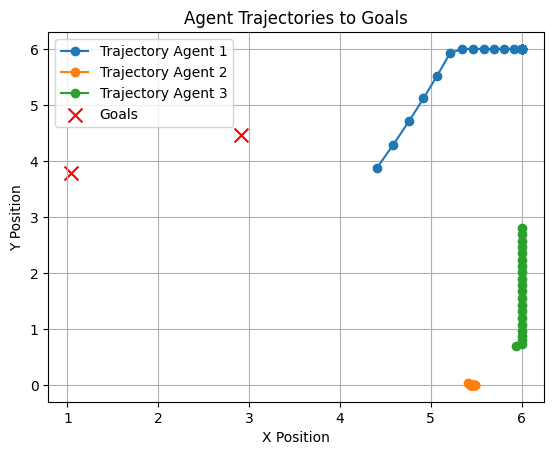

Starting position:  [[4.40501213 3.86959303]
 [5.40966071 0.03001869]
 [5.94157062 0.68851368]]
Ending position:  [[6.         6.        ]
 [5.44084132 0.        ]
 [6.         2.80337484]]


In [15]:
from matplotlib import pyplot as plt
# Initialize the environment and load the model
env = MyMultiAgentEnv()
model = PPO.load("ppo_my_multi_agent_env")

# Evaluate the trained policy
obs, info = env.reset()
trajectories = [env.positions.copy()]
for _ in range(50):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    trajectories.append(env.positions.copy())
    if done:
        break

trajectories = np.array(trajectories)

# Plot the resulting trajectories
for i in range(env.num_agents):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], marker='o', label=f'Trajectory Agent {i+1}')
plt.scatter(env.goals[:, 0], env.goals[:, 1], marker='x', color='red', label='Goals', s=100)
plt.title('Agent Trajectories to Goals')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()

print("Starting position: ", trajectories[0])
print("Ending position: ", trajectories[-1])